<a href="https://colab.research.google.com/github/ContiPaolo/Multifidelity-Tutorial/blob/main/MF_POD_Burger's1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-fidelity reduced-order modeling on Groundwater's flow - Darcy equation**

#### We aim to create a reduced-order surrogate model that enables the efficient recovery of high-fidelities solutions parameter variations, starting from their low-fidelity counterparts.

#### We consider a data-driven strategy that combines a coarser FEM solver with multi-fidelity neural network surrogates.


#### Import libraries

In [1]:
import numpy as np
#import matplotlib as plt
from matplotlib import pyplot as plt
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.optimizers import Adam,Nadam,Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
from sklearn.utils import extmath
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import KFold


#######################     CONFIGURATIONS     ##########################
seed = 29
train = True
save = True

# DATASET 
The dataset has been developed using fenics library, it is composed of 64000 samples divided in 90% training and 10% testing.\
The input (or X) are the 64 first component of the Karhunen-Loève (KL) decompositions. \
These eigenmodes allow to paratetrize a random field in the most accurate way.

The output: 25 sensors are used to record the hydraulic pressure in the domain $\Omega$ \
The sensors are distributed on a grid with positions [0.1, 0.3, 0.5, 0.7, 0.9]



Training Multi Fidelity connected neural network surrogate model

In [10]:
X_test = np.loadtxt("../../data/50-25-10/X_test_25resolution.csv" , delimiter = ",")
y_test = np.loadtxt("../../data/50-25-10/y_test_25resolution.csv" , delimiter = ",")

X_train =np.loadtxt("../../data/50-25-10/X_train_25resolution.csv" , delimiter = ",")
y_train =np.loadtxt("../../data/50-25-10/y_train_25resolution.csv" , delimiter = ",")

In [11]:
coeff = 1e-9

# Define the learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return max(lr * 0.99, 1e-7)

model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), activation='gelu', kernel_regularizer=l2(coeff)),
    Dense(256, activation='gelu', kernel_regularizer=l2(coeff)),
    Dense(256, activation='gelu', kernel_regularizer=l2(coeff)),
    Dense(256, activation='gelu', kernel_regularizer=l2(coeff)),
    Dense(256, activation='gelu', kernel_regularizer=l2(coeff)),
    Dense(256, activation='gelu', kernel_regularizer=l2(coeff)),
    Dense(25, activation='linear', kernel_regularizer=l2(coeff))
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Define the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history = model.fit(X_train, y_train, 
            epochs=1000, 
            batch_size=64, 
            validation_data=(X_test, y_test), 
            validation_freq=10,
            callbacks=[lr_scheduler])

# Save the model for each fold
model.save(f'./models/model_25resolution_fullsamples.keras')




Epoch 1/1000


/Users/filippozacchei/anaconda3/envs/fenics/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - learning_rate: 0.0010
Epoch 2/1000
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.0308e-04 - mean_squared_error: 3.0161e-04 - learning_rate: 0.0010
Epoch 3/1000
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.9900e-04 - mean_squared_error: 1.9754e-04 - learning_rate: 0.0010
Epoch 4/1000
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.5526e-04 - mean_squared_error: 1.5380e-04 - learning_rate: 0.0010
Epoch 5/1000
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.3266e-04 - mean_squared_error: 1.3118e-04 - learning_rate: 0.0010
Epoch 6/1000
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.1355e-04 - mean_squared_error: 1.1205e-04 - learning_rate: 0.0010
Epoch 7/1000
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.0142e-04 - mean_squared_error: 9.9906e-05 - learning_rate: 0.0010
Epoch 8/1000
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 9.5494e-05 - mean_squared_error: 

In [16]:
import numpy as np
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Add
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

Training = True

coeffs = [1e-8]
n_neurons = 256
n_splits = 4
n_samples = [8000, 16000]

model_lf = load_model(f'./models/model_25resolution_fullsamples.keras')

for n_sample in n_samples:
    for coeff in coeffs:
        # Load the data
        X_train_params = np.loadtxt('../../data/50-25-10/X_train_50resolution.csv', delimiter=',')[:n_sample,:]
        X_train_pod = model_lf(X_train_params).numpy()[:n_sample,:]
        y_train = np.loadtxt('../../data/50-25-10/y_train_50resolution.csv', delimiter=',')[:n_sample,:]

        print(np.mean((X_train_pod - y_train)**2))

        X_test_params = np.loadtxt('../../data/50-25-10/X_test_50resolution.csv', delimiter=',')
        X_test_pod = model_lf(X_test_params).numpy()
        y_test = np.loadtxt('../../data/50-25-10/y_test_50resolution.csv', delimiter=',')

        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            elif epoch > 1000:
                return lr*(epoch)/(1+epoch)
            else:
                return max(lr * 0.99, 1e-7)
            
        # Setting up K-Fold Cross-Validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        # Cross-validation loop
        fold_var = 1

        # Define the three branches of the model
        input_params = Input(shape=(X_train_params.shape[1],))
        input_pod = Input(shape=(X_train_pod.shape[1],))

        # Define the first branch (parameters)
        x1 = Dense(n_neurons, activation='gelu', kernel_regularizer=l2(coeff))(input_params)
        x1 = Dense(n_neurons, activation='gelu', kernel_regularizer=l2(coeff))(x1)
        x1 = Dense(n_neurons, activation='gelu', kernel_regularizer=l2(coeff))(x1)
        x1 = Dense(n_neurons, activation='gelu', kernel_regularizer=l2(coeff))(x1)
        x1 = Dense(n_neurons, activation='gelu', kernel_regularizer=l2(coeff))(x1)
        x1 = Dense(n_neurons, activation='gelu', kernel_regularizer=l2(coeff))(x1)

        # Define the second branch (POD)
        x2 = Dense(n_neurons, activation='gelu', kernel_regularizer=l2(coeff))(input_pod)

        # # Define the second branch (POD)
        # x3 = Dense(n_neurons, activation='gelu', kernel_regularizer=l2(w))(input_nn)

        # Combine the outputs of the three branches
        combined = Add()([x1,x2])
        combined = Dense(n_neurons, activation='gelu', kernel_regularizer=l2(coeff))(combined)
        output = Dense(25, activation='linear', kernel_regularizer=l2(coeff))(combined)

        # Create the model
        model = Model(inputs=[input_params,input_pod], outputs=output)

        for train_index, val_index in kf.split(X_train_params):

            print(f"Training fold {fold_var}...")

            # Splitting the data into training and validation sets
            X_train_params_k, X_val_params_k = X_train_params[train_index], X_train_params[val_index]
            X_train_pod_k, X_val_pod_k = X_train_pod[train_index], X_train_pod[val_index]
            y_train_k, y_val_k = y_train[train_index], y_train[val_index]

            # Compile the model
            initial_learning_rate = 0.001
            optimizer = Adam(learning_rate=initial_learning_rate)
            model.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['mean_squared_error'])

            # Define the learning rate scheduler callback
            lr_scheduler = LearningRateScheduler(scheduler)

            # Train the model
            history = model.fit([X_train_params_k, X_train_pod_k], y_train_k,
                                epochs=1000,
                                batch_size=64,
                                validation_data=([X_val_params_k, X_val_pod_k], y_val_k),
                                validation_freq=10,
                                callbacks=[lr_scheduler])
            
            # Save the model for each fold
            model.save(f'./models/model_2step_50-25resolution_{n_sample}samples_{fold_var}.keras')

            # Increment the fold number
            fold_var += 1




1.7508042677687216e-05
Training fold 1...
Epoch 1/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - learning_rate: 0.0010
Epoch 2/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - learning_rate: 0.0010
Epoch 3/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6793e-04 - mean_squared_error: 6.5020e-04 - learning_rate: 0.0010
Epoch 4/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5091e-04 - mean_squared_error: 4.3317e-04 - learning_rate: 0.0010
Epoch 5/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4089e-04 - mean_squared_error: 3.2315e-04 - learning_rate: 0.0010
Epoch 6/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7570e-04 - mean_squared_error: 2.5798e-04 - learning_rate: 0.0010
Epoch 7/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2899e-04 - mean_squared_error: 2.1128e-04 - learning_rate: 0.0010
Epoch 8/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9223e-04 - mean_

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

model_lf = load_model(f'./models/model_25resolution_fullsamples.keras')

# Parameters
n_splits = 4
n_samples = [1000, 2000, 4000, 8000, 16000]
models = ['50-10resolution', '50-25resolution', '2step_50-10resolution', '2step_50-25resolution']
colors = {'50-10resolution': 'red', '50-25resolution': 'blue', '2step_50-10resolution': 'red', '2step_50-25resolution': "blue"}
markers = {'50-10resolution': 'D', '50-25resolution': 'x', '2step_50-10resolution': 'D', '2step_50-25resolution': 'x'}
linestyles = {'50-10resolution': '--', '50-25resolution': '--', '2step_50-10resolution': "-", '2step_50-25resolution': "-"}

# Storage for RMSE results (mean and standard deviation)
rmse_test_mean = {model: [] for model in models}
rmse_test_std = {model: [] for model in models}

# Loop over different models
for model in models:
    print(f"Processing model: {model}")

    # Load data according to the model
    X_train_50 = np.loadtxt("../../data/50-25-10/X_train_50resolution.csv", delimiter=",")

    y_train = np.loadtxt("../../data/50-25-10/y_train_50resolution.csv", delimiter=",")

    for n_sample in n_samples:

        if model == "2step_50-10resolution":
            model_lf = load_model(f'./models/model_10resolution_64000samples_1.keras')
            X_train_10 = model_lf(X_train_50).numpy()[:n_sample,:]

        elif model == "2step_50-25resolution":
            model_lf = load_model(f'./models/model_25resolution_64000samples_1.keras')
            X_train_10 = model_lf(X_train_50).numpy()[:n_sample,:]

        elif model == "50-10resolution":
            X_train_10 = np.loadtxt('../../data/50-25-10/y_train_10resolution_mfdata.csv', delimiter=',')[:n_sample,:]

        elif model == "50-25resolution":
            X_train_10 = np.loadtxt('../../data/50-25-10/y_train_25resolution_mfdata.csv', delimiter=',')[:n_sample,:]

        kf = KFold(n_splits=n_splits)

        X = (X_train_50[:n_sample, :], X_train_10[:n_sample,:])
            
        y = y_train[:n_sample, :]

        rmse_test = []

        fold_var = 1

        for train_index, val_index in kf.split(y):  # Only split y to keep tuples intact for X
            print(f"Training fold {fold_var} with {n_sample} samples...")

            # Splitting the data into training and validation sets
            X_train_k = (X[0][train_index], X[1][train_index])
            X_val_k = (X[0][val_index], X[1][val_index])
            
            y_train_k, y_val_k = y[train_index], y[val_index]

            # Load the model for the current fold and model type
            model_path = f'./models/model_{model}_{n_sample}samples_{fold_var}.keras'
            trained_model = load_model(model_path)

            # Calculate RMSE for validation set
            test_err = trained_model(X_val_k).numpy() - y_val_k
            rmse_test_fold = np.sqrt(np.mean(test_err**2))
            rmse_test.append(rmse_test_fold)
            
            # Increment the fold number
            fold_var += 1
    
        # Store the mean and standard deviation of RMSE results for the current sample size and model
        rmse_test_mean[model].append(np.mean(rmse_test))
        rmse_test_std[model].append(np.std(rmse_test))

# Plotting the results
plt.figure(figsize=(12, 8))

for model in models:
    plt.errorbar(n_samples, rmse_test_mean[model], yerr=rmse_test_std[model], linestyle=linestyles[model],
                 marker=markers[model], color=colors[model], label=model, capsize=5)

plt.xticks(n_samples, fontsize=12)
plt.xlabel('Number of Data Samples', fontsize=14)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=14)
plt.legend(['50-10 Multi Fidelity'], loc='upper right', fontsize=12, frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xscale('log')
plt.tight_layout()
plt.show()

Processing model: 50-10resolution


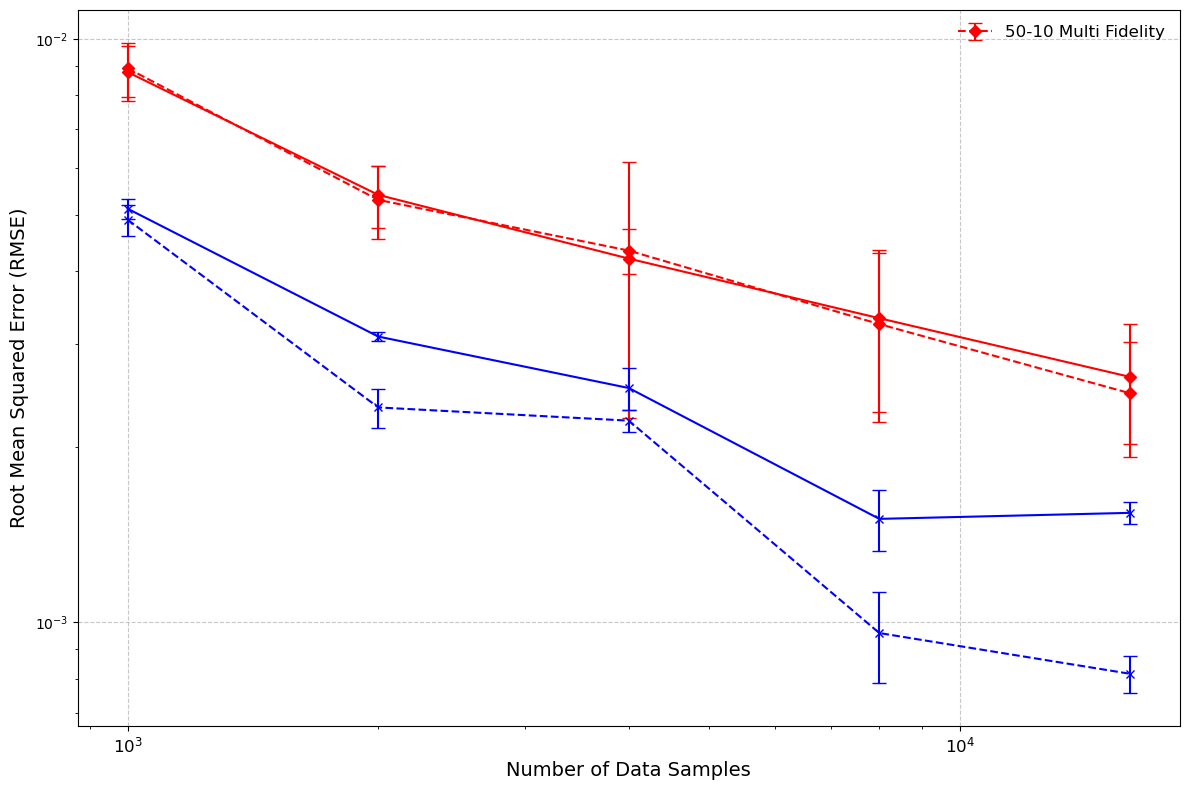

In [22]:
# Plotting the results
plt.figure(figsize=(12, 8))

for model in models:
    plt.errorbar(n_samples, rmse_test_mean[model], yerr=rmse_test_std[model], linestyle=linestyles[model],
                 marker=markers[model], color=colors[model], label=model, capsize=5)

plt.xticks(n_samples, fontsize=12)
plt.xlabel('Number of Data Samples', fontsize=14)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=14)
plt.legend(['50-10 Multi Fidelity'], loc='upper right', fontsize=12, frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

# Errors

10-10 resolution : 50-50 resolution

1000 data, benchmark: 
1e-6, err: 2.05e-04
1e-7, err: 1.22e-04
1e-8, err: 1.01e-04

2000 data, benchmark: 
1e-6, err:
1e-7, err:
1e-8, err:

4000 data, benchmark: 
1e-6, err:
1e-7, err:
1e-8, err:

8000 data, benchmark: 
1e-6, err:
1e-7, err:
1e-8, err:

16000 data, benchmark: 
1e-7, err:
1e-8, err:
1e-9, err:

32000 data, benchmark: 
1e-7, err:
1e-8, err:
1e-9, err:

64000 data, benchmark: 
1e-7, err:
1e-8, err:
1e-9, err:

In [ ]:
model = load_model(f'./models/model_50-10resolution_{n_sample}samples_4.keras')
model((X_test_params,X_test_pod)).numpy()

array([[0.9412804 , 0.96021557, 0.9310102 , ..., 0.11300899, 0.10804499,
        0.08837804],
       [0.9211987 , 0.9238984 , 0.9598889 , ..., 0.06384155, 0.06865404,
        0.08434081],
       [0.9307978 , 0.9188586 , 0.8705659 , ..., 0.07316414, 0.15586762,
        0.1932146 ],
       ...,
       [0.9303663 , 0.8583942 , 0.8404265 , ..., 0.14173916, 0.07137661,
        0.06788851],
       [0.95010877, 0.92889416, 0.9032178 , ..., 0.09457538, 0.10062466,
        0.08408783],
       [0.8260754 , 0.74899834, 0.85366315, ..., 0.1172493 , 0.10054297,
        0.10147938]], dtype=float32)